In [175]:
import gzip

def loadfasta(filename,verbose=0):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a dictionary where the key
        for a sequence is the first part of its header without 
        any white space; if verbose is nonzero then the identifiers 
        together with lengths of the read sequences are printed"""
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rt')
    else:
        fp = open(filename, 'r')
    # split at headers
    # data = fp.read().split('>')
    data = fp.read()
    data = data.split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    # prepare the dictionary
    D = {}
    for sequence in data:
        lines = sequence.split('\n')
        header = lines.pop(0).split()
        key = header[0]
        D[key] = ''.join(lines)
        if verbose:
            print("Sequence %s of length %d read" % (key,len(D[key])))
    return D

seq = loadfasta('MotSam.fasta')
seq.keys()

dict_keys(['Seq0', 'Seq1', 'Seq2', 'Seq3', 'Seq4', 'Seq5', 'Seq6', 'Seq7', 'Seq8', 'Seq9'])

In [176]:
import time
import random
import numpy as np
from functools import reduce
import operator
import copy
from math import sqrt

In [177]:
BASES = 'ATCG'

In [178]:
indices = {s:idx for idx, s in enumerate(BASES)}
indices

{'A': 0, 'T': 1, 'C': 2, 'G': 3}

In [179]:
def product(iterable):
    return reduce(operator.mul, iterable, 1)

In [180]:
# Test
product([2,3,5])

30

In [181]:
def compute_background_frequencies(sequences, verbose=False):
    Q = np.zeros((4,)) # A, T, C, G
    n = 0
    for seq in sequences:
        for idx in range(len(seq)):
            Q[seq[idx]] += 1
            n += 1
    
    for base in range(4):
            Q[base] /= n
    
    if verbose:
        print('Frequencies:')
        print(Q)
    
    return Q

In [182]:
# Test
result = compute_background_frequencies(np.array([[0,1,1,2,3,1], [1,0,1,3,2,1], [0,0,1,1,1,0,0,0], [3,2,3,3,0,1]]), verbose=True)
print(sum(result))

Frequencies:
[0.30769231 0.38461538 0.11538462 0.19230769]
1.0


In [284]:
def profile(lmers, Q, beta, verbose=False):
    L = len(lmers[0])
    if any(map(lambda x: len(x) != L, lmers)):
        raise Exception("Wrong lengths")
    
    profile = np.zeros((4,L)) # A, T, C, G
    for lmer in lmers:
        for i in range(L):
            profile[lmer[i]][i] += 1
    
    for i in range(4):
        B = beta * Q[i]
        for j in range(L):
            profile[i][j] += B
            
    for i in range(4):
        for col in range(L):
            profile[i][col] /= (len(lmers)+beta)
    
    if verbose:
        print('Profile:')
        print(profile)
        
    return profile

In [290]:
# Test
print(profile(np.array([[0,1,1,3,2], [0,1,3,1,2]]), [0,0,0,0], 2))
try:
    print(profile([[0,1,1,3,2], [0,1,3,1,2,1]], [0,0,0,0], 2))
except Exception:
    print('Wrong lengths')

[[0.5  0.   0.   0.   0.  ]
 [0.   0.5  0.25 0.25 0.  ]
 [0.   0.   0.   0.   0.5 ]
 [0.   0.   0.25 0.25 0.  ]]
Wrong lengths


In [334]:
def build_profile(lmers, positions, length, Q, verbose=False):
    """ Builds profile from lmers given position and length of motif suspects
    """
    return profile([ lmers[i][positions[i]:positions[i]+length] for i in range(len(lmers)) ], Q, 1/length, verbose=verbose)

In [335]:
# Test
build_profile(np.array([[0,0,0,1,1,3,2], [0,1,3,1,2,0,0]]), [2, 0], 5, [0.25,0.25,0.25,0.25], verbose=True)

Profile:
[[0.93181818 0.02272727 0.02272727 0.02272727 0.02272727]
 [0.02272727 0.93181818 0.47727273 0.47727273 0.02272727]
 [0.02272727 0.02272727 0.02272727 0.02272727 0.93181818]
 [0.02272727 0.02272727 0.47727273 0.47727273 0.02272727]]


array([[0.93181818, 0.02272727, 0.02272727, 0.02272727, 0.02272727],
       [0.02272727, 0.93181818, 0.47727273, 0.47727273, 0.02272727],
       [0.02272727, 0.02272727, 0.02272727, 0.02272727, 0.93181818],
       [0.02272727, 0.02272727, 0.47727273, 0.47727273, 0.02272727]])

In [336]:
def skip(lmers, h):
    for idx, lmer in enumerate(lmers):
        if idx == h:
            continue
        
        yield lmer

In [337]:
# Test
sum(skip([1,2,3],1))

4

In [338]:
def compute_Q(lmers, h, verbose=False):
    """ Compute background frequencies of given lmers while skipping the `h`th one.
    """
    return compute_background_frequencies(skip(lmers, h), verbose=verbose)

In [339]:
# Test
compute_Q([[0,1,3,2],[3,3,2,2],[0,0,0,0]], 1, verbose=True)

Frequencies:
[0.625 0.125 0.125 0.125]


array([0.625, 0.125, 0.125, 0.125])

In [340]:
def compute_X(lmers, positions, length, h, Q, verbose=False):
    """ Compute profile for suspect motifs on positions of given lmers while skipping the `h`th one.
    """
    return build_profile(list(skip(lmers, h)), list(skip(positions, h)), length, Q, verbose=verbose)

In [341]:
# Test
compute_X([[0,1,3,2],[3,3,2,2],[0,0,0,0]], [0,0,0], 2, 1, [0.25, 0.25, 0.25, 0.25], verbose=True)

Profile:
[[0.85 0.45]
 [0.05 0.45]
 [0.05 0.05]
 [0.05 0.05]]


array([[0.85, 0.45],
       [0.05, 0.45],
       [0.05, 0.05],
       [0.05, 0.05]])

In [342]:
def weight_based_on_profile(motif, profile):
    if len(motif) != len(profile[0]):
        raise Exception("Lengths are supposed to be the same.")
        
    p = 1
    for i in range(len(motif)):
        p *= profile[motif[i]][i]
        
    return p

In [343]:
# Test
weight_based_on_profile([0,1,2], np.array([[0.25, 0.1, 0.25], [0.5, 0.1, 0.25], [0.25, 0.1, 0.25], [0, 0.7, 0.25]]))

0.00625

In [344]:
def weight_based_on_frequency(motif, frequency):
    p = 1
    for i in range(len(motif)):
        p *= frequency[motif[i]]
        
    return p

In [345]:
# Test
weight_based_on_frequency([0,1,2], np.array([0.1,0.3,0.5,0.1]))

0.015

In [346]:
def find_motif_probs(lmer, length, X, Q, verbose=False):
    L = len(lmer)
    weights = []
    S = 0
    for i in range(0, L-length+1):
        motif = lmer[i:i+length]
        pX = weight_based_on_profile(motif, X)
        pQ = weight_based_on_frequency(motif, Q)
        
        w = pX / pQ
        weights.append(w)
        S += w
    
    result = np.array(weights) / S
    if verbose:
        print('Motif probabilities:')
        print(result)
        
    return result

In [347]:
# Test
find_motif_probs([0,0,1,1,2,2], 3, np.array([[0.25, 0.1, 0.25], [0.5, 0.1, 0.25], [0.25, 0.1, 0.25], [0, 0.7, 0.25]]), np.array([0.1,0.3,0.5,0.1]), verbose=True)

Motif probabilities:
[0.64655172 0.21551724 0.0862069  0.05172414]


array([0.64655172, 0.21551724, 0.0862069 , 0.05172414])

In [348]:
def select_position(probs, verbose=False):
    x = random.random()
    if verbose:
        print('Chosen x: {}'.format(x))
    
    i = 0
    S = probs[i]
    while S < x:
        i += 1
        S += probs[i]
    
    result = min(len(probs)-1, i)
    
    if verbose:
        print('Selected position: {}'.format(result))
    
    return result

In [349]:
# Test
select_position([0.1, 0.25, 0.5, 0.15], verbose=True)

Chosen x: 0.8241914167974153
Selected position: 2


2

In [350]:
def gibbs_step(lmers, positions, length, verbose=False):
    """ Does a step of gibbs motif search algorithm and returns whether the position was changed.
    """
    L = len(lmers)
    h = random.randint(0, L-1)
    if verbose:
        print('h: {}'.format(h))
    
    Q = compute_Q(lmers, h, verbose=verbose)
    X = compute_X(lmers, positions, length, h, Q, verbose=verbose)
    
    probs = find_motif_probs(lmers[h], length, X, Q, verbose=verbose)
    
    old_position = positions[h]
    positions[h] = select_position(probs, verbose=verbose)
    
    return old_position != positions[h]

In [351]:
# Test
random.seed(12345)
gibbs_step(np.array([[0,1,2,3,0,0], [0,0,2,2,0,1,1], [0,1,2,1,3]]), [0, 3, 1], 3, verbose=True)

h: 1
Frequencies:
[0.36363636 0.27272727 0.18181818 0.18181818]
Profile:
[[0.48051948 0.05194805 0.05194805]
 [0.46753247 0.46753247 0.46753247]
 [0.02597403 0.45454545 0.45454545]
 [0.02597403 0.02597403 0.02597403]]
Motif probabilities:
[0.03715979 0.65029627 0.00401727 0.0027547  0.30577196]
Chosen x: 0.7326852754516092
Selected position: 4


True

In [352]:
def score_motifs(motifs, verbose=False):
    """ Returns largest distance, score of motifs and mean motif
    """
    L = len(motifs[0])
    if any(map(lambda x: len(x) != L, motifs)):
        raise Exception('Motfs must have the same length.')
        
    M = len(motifs)
    score = np.zeros((4, L))
    
    for motif in motifs:
        for i in range(L):
            score[motif[i]][i] += 1
    
    score = score.transpose()
    S = sum([max(x) for x in score])/(M*L)
    mean = [np.argmax(x) for x in score]
    D = max([sum(map(lambda x: int(x != 0), mean - motif)) for motif in motifs])
    
    if verbose:
        print('Largest distance: {}'.format(D))
        print('Score: {}'.format(S))
        print('Mean: {}'.format(mean))
    
    return (D, S, mean)

In [353]:
# Test
score_motifs(np.array([[3,3,3,3],[1,1,1,1],[2,2,2,2]]), verbose=True)

Largest distance: 4
Score: 0.3333333333333333
Mean: [1, 1, 1, 1]


(4, 0.3333333333333333, [1, 1, 1, 1])

In [354]:
def score(lmers, positions, length, verbose=False):
    return score_motifs(
        np.array([lmer[positions[idx]:positions[idx]+length] for idx, lmer in enumerate(lmers)]),
        verbose=verbose)

In [355]:
# Test
score(np.array([[3,3,3,3,3,3],[1,1,1,1,1,1],[2,2,2,2,2,2]]), np.array([0,0,1]), 4, verbose=True)

Largest distance: 4
Score: 0.3333333333333333
Mean: [1, 1, 1, 1]


(4, 0.3333333333333333, [1, 1, 1, 1])

In [356]:
def change_to_numbers(lmers):
    return [[BASES.index(x) for x in lmer] for lmer in lmers]

In [357]:
# Test
print(change_to_numbers(['AATT','CCGG']))

[[0, 0, 1, 1], [2, 2, 3, 3]]


In [358]:
def shift_positions(positions, length, L, verbose=False):
    amount = random.randint(0, length*2)-length
    position = random.randint(0, len(positions)-1)
    
    if verbose:
        print('Amount of positions to be shifted: {}'.format(amount))
        print('Position to be shifted: {}'.format(position))
        
    positions[position] = max(0, min(L[position]-length, positions[position]+amount))
    
    if verbose:
        print('Resulting positions: {}'.format(positions))

In [359]:
# Test
random.seed(12344)
shift_positions([1, 0, 2, 3, 5], 5, [10, 10, 10, 10, 10], verbose=True)

Amount of positions to be shifted: -3
Position to be shifted: 3
Resulting positions: [1, 0, 2, 0, 5]


In [366]:
def gibbs(lmers, length=15, difference=4, M=20, S=None, verbose=False):
    """ Accepts lmers, length of motif and maximal difference and tries to find the planted motif
    """
    lmers = np.array(change_to_numbers(lmers))
    L = [len(lmer) for lmer in lmers]
    if S == None:
        S = len(lmers) * 10
    positions = np.array([random.randint(0, len(lmer)-length-1) for lmer in lmers])
    
    if verbose:
        print('Positions: {}'.format(positions))
    
    m = successes = 0
    scores = []
    scores.append(score(lmers, positions, length, verbose=verbose))
    
    while successes < S:
        changed = gibbs_step(lmers, positions, length, verbose=verbose)
        scores.append(score(lmers, positions, length, verbose=verbose))
        
        if not changed:
            m += 1
        else:
            m = 0
            
        if m == M:
            if verbose:
                print('There were {} steps without change'.format(M))
                
            shift_positions(positions, length, L, verbose=verbose)
            m = 0
            successes += 1
    
    return scores

In [367]:
# Test
gibbs(['AATATTCG', 'TTTTGTCC', 'GCATTTTT', 'ACTTTTGT'], 4, 1, M=10, S=5, verbose=True)

Positions: [0 2 2 1]
Largest distance: 2
Score: 0.6875
Mean: [0, 1, 1, 1]
h: 3
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.62820513 0.32051282 0.01282051 0.32051282]
 [0.34935897 0.65705128 0.65705128 0.65705128]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.31730769 0.00961538]]
Motif probabilities:
[0.10164602 0.03271183 0.27427611 0.01739312 0.57397292]
Chosen x: 0.7743348509339886
Selected position: 4
Largest distance: 2
Score: 0.625
Mean: [0, 1, 1, 1]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.63141026 0.32371795 0.01602564 0.32371795]
 [0.34935897 0.65705128 0.65705128 0.65705128]
 [0.00961538 0.00961538 0.00961538 0.00961538]
 [0.00961538 0.00961538 0.31730769 0.00961538]]
Motif probabilities:
[3.16395762e-01 2.00641215e-02 6.62116009e-01 1.27235892e-03
 1.51749229e-04]
Chosen x: 0.024079273879082708
Selected position: 0
Largest distance: 2
Score: 0.6875
Mean: [0, 1, 1, 1]
h: 0
Frequencies:


Chosen x: 0.43040932925856734
Selected position: 4
Largest distance: 2
Score: 0.8125
Mean: [1, 1, 3, 1]
h: 2
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.32051282 0.01282051 0.32051282 0.01282051]
 [0.65705128 0.96474359 0.04166667 0.96474359]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.625      0.00961538]]
Motif probabilities:
[0.01872543 0.00074902 0.43356572 0.27347992 0.27347992]
Chosen x: 0.6374073081778876
Selected position: 3
Largest distance: 2
Score: 0.8125
Mean: [1, 1, 3, 1]
h: 2
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.32051282 0.01282051 0.32051282 0.01282051]
 [0.65705128 0.96474359 0.04166667 0.96474359]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.625      0.00961538]]
Motif probabilities:
[0.01872543 0.00074902 0.43356572 0.27347992 0.27347992]
Chosen x: 0.8043075636855831
Selected position: 4
Largest distance: 2
Score: 0.8125
Mean: [1, 1, 3, 1]
h: 0
Frequ

Score: 0.9375
Mean: [1, 1, 1, 1]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.01602564 0.32371795 0.01602564 0.01602564]
 [0.96474359 0.65705128 0.96474359 0.96474359]
 [0.00961538 0.00961538 0.00961538 0.00961538]
 [0.00961538 0.00961538 0.00961538 0.00961538]]
Motif probabilities:
[9.18106601e-01 3.96524446e-02 3.96524446e-02 2.51454527e-03
 7.39645603e-05]
Chosen x: 0.75537491492073
Selected position: 0
Largest distance: 1
Score: 0.9375
Mean: [1, 1, 1, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.00641026]
 [0.97115385 0.97115385 0.97115385 0.97115385]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.00961538]]
Motif probabilities:
[0.00212929 0.04301167 0.8688357  0.04301167 0.04301167]
Chosen x: 0.5229449916691683
Selected position: 2
Largest distance: 1
Score: 0.9375
Mean: [1, 1, 1, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     

Motif probabilities:
[1.13229270e-01 8.77786540e-01 7.18039271e-03 5.83246870e-04
 1.22055077e-03]
Chosen x: 0.1402473124336796
Selected position: 1
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.01602564 0.01602564 0.01602564 0.01602564]
 [0.96474359 0.96474359 0.65705128 0.34935897]
 [0.00961538 0.00961538 0.31730769 0.00961538]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[1.13229270e-01 8.77786540e-01 7.18039271e-03 5.83246870e-04
 1.22055077e-03]
Chosen x: 0.6655290751077726
Selected position: 1
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 3
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.01282051 0.01282051 0.01282051 0.01282051]
 [0.96474359 0.96474359 0.65705128 0.34935897]
 [0.01282051 0.01282051 0.32051282 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[2.10514782e-04 4.87422689e-03 1.12857099e-01 8.74901

 4.73534487e-01]
Chosen x: 0.3143127556643418
Selected position: 3
Largest distance: 1
Score: 0.9375
Mean: [1, 1, 1, 1]
h: 2
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.01282051 0.32051282 0.01282051 0.01282051]
 [0.96474359 0.65705128 0.96474359 0.96474359]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.00961538]]
Motif probabilities:
[5.60137719e-05 3.24233564e-02 2.04516556e-02 4.73534487e-01
 4.73534487e-01]
Chosen x: 0.24189569987789594
Selected position: 3
Largest distance: 1
Score: 0.9375
Mean: [1, 1, 1, 1]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.01602564 0.32371795 0.01602564 0.01602564]
 [0.96474359 0.65705128 0.96474359 0.96474359]
 [0.00961538 0.00961538 0.00961538 0.00961538]
 [0.00961538 0.00961538 0.00961538 0.00961538]]
Motif probabilities:
[9.18106601e-01 3.96524446e-02 3.96524446e-02 2.51454527e-03
 7.39645603e-05]
Chosen x: 0.9766791521282252
Selected position: 2
Larg

[0.17074026 0.08067946 0.67646627 0.04289786 0.02921615]
Chosen x: 0.8147282453753842
Selected position: 2
Largest distance: 1
Score: 0.8125
Mean: [0, 1, 1, 1]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.63141026 0.01602564 0.01602564 0.01602564]
 [0.34935897 0.96474359 0.96474359 0.65705128]
 [0.00961538 0.00961538 0.00961538 0.31730769]
 [0.00961538 0.00961538 0.00961538 0.00961538]]
Motif probabilities:
[0.82797556 0.05250577 0.03575974 0.0748338  0.00892513]
Chosen x: 0.7986097612006462
Selected position: 0
Largest distance: 1
Score: 0.8125
Mean: [0, 1, 1, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.31410256 0.00641026 0.00641026 0.00641026]
 [0.66346154 0.97115385 0.97115385 0.97115385]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.00961538]]
Motif probabilities:
[0.02111013 0.42642472 0.12009512 0.42642472 0.0059453 ]
Chosen x: 0.10114033681093149
Selected position: 1
Larges

[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.01282051 0.32051282 0.01282051 0.01282051]
 [0.96474359 0.65705128 0.34935897 0.96474359]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.625      0.00961538]]
Motif probabilities:
[1.54664972e-04 3.24201576e-02 2.04496379e-02 4.73487770e-01
 4.73487770e-01]
Chosen x: 0.8538925226876859
Selected position: 4
Largest distance: 1
Score: 0.8125
Mean: [1, 1, 1, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.00641026]
 [0.97115385 0.97115385 0.35576923 0.97115385]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.625      0.00961538]]
Motif probabilities:
[0.0018535  0.10220275 0.75630038 0.03744061 0.10220275]
Chosen x: 0.5787018520159921
Selected position: 2
Largest distance: 1
Score: 0.8125
Mean: [1, 1, 1, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.0

Largest distance: 1
Score: 0.8125
Mean: [1, 1, 1, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.00641026]
 [0.97115385 0.97115385 0.97115385 0.35576923]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[6.70654827e-04 4.96284572e-03 1.00249484e-01 1.35472275e-02
 8.80569788e-01]
Chosen x: 0.9970363838660905
Selected position: 4
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.00641026]
 [0.97115385 0.97115385 0.97115385 0.35576923]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[6.70654827e-04 4.96284572e-03 1.00249484e-01 1.35472275e-02
 8.80569788e-01]
Chosen x: 0.8542745077967805
Selected position: 4
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 0
Frequencies:
[0.

Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.01282051 0.01282051 0.01282051 0.01282051]
 [0.96474359 0.96474359 0.65705128 0.04166667]
 [0.01282051 0.01282051 0.32051282 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.93269231]]
Motif probabilities:
[5.78379856e-05 9.12060542e-04 2.11177095e-02 4.88956196e-01
 4.88956196e-01]
Chosen x: 0.34353386009360665
Selected position: 3
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.01602564 0.01602564 0.01602564 0.01602564]
 [0.96474359 0.96474359 0.65705128 0.34935897]
 [0.00961538 0.00961538 0.31730769 0.00961538]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[1.13229270e-01 8.77786540e-01 7.18039271e-03 5.83246870e-04
 1.22055077e-03]
Chosen x: 0.7412323538076322
Selected position: 1
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.0

Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.63141026 0.01602564 0.32371795 0.01602564]
 [0.34935897 0.96474359 0.34935897 0.96474359]
 [0.00961538 0.00961538 0.00961538 0.00961538]
 [0.00961538 0.00961538 0.31730769 0.00961538]]
Motif probabilities:
[2.00744809e-01 8.67004160e-03 7.90087369e-01 3.74453624e-04
 1.23326069e-04]
Chosen x: 0.3040515632404345
Selected position: 2
Largest distance: 1
Score: 0.75
Mean: [0, 1, 3, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.31410256 0.00641026 0.00641026 0.00641026]
 [0.66346154 0.97115385 0.35576923 0.97115385]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.625      0.00961538]]
Motif probabilities:
[0.01207754 0.66596222 0.06870889 0.24396636 0.00928499]
Chosen x: 0.16603069967068163
Selected position: 1
Largest distance: 1
Score: 0.75
Mean: [0, 1, 3, 1]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.31410256 0.00641026 0.00

h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.62179487 0.00641026 0.00641026 0.00641026]
 [0.35576923 0.66346154 0.66346154 0.97115385]
 [0.01282051 0.32051282 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.31730769 0.00961538]]
Motif probabilities:
[0.02730948 0.55165152 0.04208476 0.37687084 0.0020834 ]
Chosen x: 0.952449460230508
Selected position: 3
Largest distance: 2
Score: 0.75
Mean: [0, 1, 1, 1]
h: 2
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.62820513 0.01282051 0.01282051 0.01282051]
 [0.34935897 0.65705128 0.65705128 0.65705128]
 [0.01282051 0.32051282 0.01282051 0.32051282]
 [0.00961538 0.00961538 0.31730769 0.00961538]]
Motif probabilities:
[0.00152481 0.0009618  0.74317664 0.12716837 0.12716837]
Chosen x: 0.15975641281389186
Selected position: 2
Largest distance: 2
Score: 0.75
Mean: [0, 1, 1, 1]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.93910256 0.01602564 0.01602564 0.01602564

 8.80569788e-01]
Chosen x: 0.5132971997671884
Selected position: 4
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.00641026]
 [0.97115385 0.97115385 0.97115385 0.35576923]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[6.70654827e-04 4.96284572e-03 1.00249484e-01 1.35472275e-02
 8.80569788e-01]
Chosen x: 0.586342359408554
Selected position: 4
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 0
Frequencies:
[0.08333333 0.625      0.16666667 0.125     ]
Profile:
[[0.00641026 0.00641026 0.00641026 0.00641026]
 [0.97115385 0.97115385 0.97115385 0.35576923]
 [0.01282051 0.01282051 0.01282051 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[6.70654827e-04 4.96284572e-03 1.00249484e-01 1.35472275e-02
 8.80569788e-01]
Chosen x: 0.6537597014307803
Selected position: 4
Largest 

Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 2
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.01282051 0.01282051 0.01282051 0.01282051]
 [0.96474359 0.96474359 0.65705128 0.04166667]
 [0.01282051 0.01282051 0.32051282 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.93269231]]
Motif probabilities:
[5.78379856e-05 9.12060542e-04 2.11177095e-02 4.88956196e-01
 4.88956196e-01]
Chosen x: 0.8117630849749369
Selected position: 4
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 2
Frequencies:
[0.16666667 0.54166667 0.16666667 0.125     ]
Profile:
[[0.01282051 0.01282051 0.01282051 0.01282051]
 [0.96474359 0.96474359 0.65705128 0.04166667]
 [0.01282051 0.01282051 0.32051282 0.01282051]
 [0.00961538 0.00961538 0.00961538 0.93269231]]
Motif probabilities:
[5.78379856e-05 9.12060542e-04 2.11177095e-02 4.88956196e-01
 4.88956196e-01]
Chosen x: 0.7421657163629594
Selected position: 4
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 2
Frequencies:
[0.1

Chosen x: 0.7488741131131218
Selected position: 1
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.01602564 0.01602564 0.01602564 0.01602564]
 [0.96474359 0.96474359 0.65705128 0.34935897]
 [0.00961538 0.00961538 0.31730769 0.00961538]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[1.13229270e-01 8.77786540e-01 7.18039271e-03 5.83246870e-04
 1.22055077e-03]
Chosen x: 0.6063594043465705
Selected position: 1
Largest distance: 1
Score: 0.875
Mean: [1, 1, 1, 3]
h: 1
Frequencies:
[0.20833333 0.54166667 0.125      0.125     ]
Profile:
[[0.01602564 0.01602564 0.01602564 0.01602564]
 [0.96474359 0.96474359 0.65705128 0.34935897]
 [0.00961538 0.00961538 0.31730769 0.00961538]
 [0.00961538 0.00961538 0.00961538 0.625     ]]
Motif probabilities:
[1.13229270e-01 8.77786540e-01 7.18039271e-03 5.83246870e-04
 1.22055077e-03]
Chosen x: 0.6705671657378599
Selected position: 1
Largest distance: 1
Scor

[(2, 0.6875, [0, 1, 1, 1]),
 (2, 0.625, [0, 1, 1, 1]),
 (2, 0.6875, [0, 1, 1, 1]),
 (2, 0.75, [0, 1, 1, 1]),
 (1, 0.8125, [0, 1, 1, 1]),
 (1, 0.8125, [0, 1, 1, 1]),
 (2, 0.875, [1, 1, 1, 1]),
 (2, 0.875, [1, 1, 1, 1]),
 (2, 0.8125, [1, 1, 1, 1]),
 (2, 0.8125, [1, 1, 3, 1]),
 (1, 0.8125, [1, 1, 1, 1]),
 (1, 0.8125, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.9375, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.8125, [1, 1, 1, 1]),
 (1, 0.8125, [1, 1, 1, 1]),
 (1, 0.8125, [1, 1, 1, 1]),
 (2, 0.75, [1, 0, 1, 1]),
 (2, 0.75, [1, 0, 1, 1]),
 (2, 0.75, [1, 0, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [1, 1, 1, 1]),
 (1, 0.875, [

In [413]:
random.seed(12345)

start = time.time()

results = []
iterations = 0
while not any(filter(lambda result: result[0] < 5, results)):
    iterations += 1
    results += gibbs(seq.values(), M=20, S=30) # ~25% chance that we will not touch a sequence, we want 30 phase shifts
    print(iterations)

end = time.time()
motif_search_time = end-start

print("Done in {} seconds.".format(motif_search_time))

1
2
3
4
5
6
7
8
9
10
Done in 364.7794644832611 seconds.


In [414]:
candidates = list(filter(lambda result: result[0] < 5, results))
max_score = 0
best = (None,None,None)
for D, S, M in candidates:
    if S > max_score:
        max_score = S
        best = (D, S, M)

print(best)
motif = 'None'
if best[2] != None:
    motif = ''.join([BASES[b] for b in best[2]])

print('Motif: {}'.format(motif))

(4, 0.8333333333333334, [3, 1, 3, 0, 2, 0, 2, 0, 1, 1, 0, 1, 3, 1, 2])
Motif: GTGACACATTATGTC


In [415]:
import matplotlib.pyplot as plt

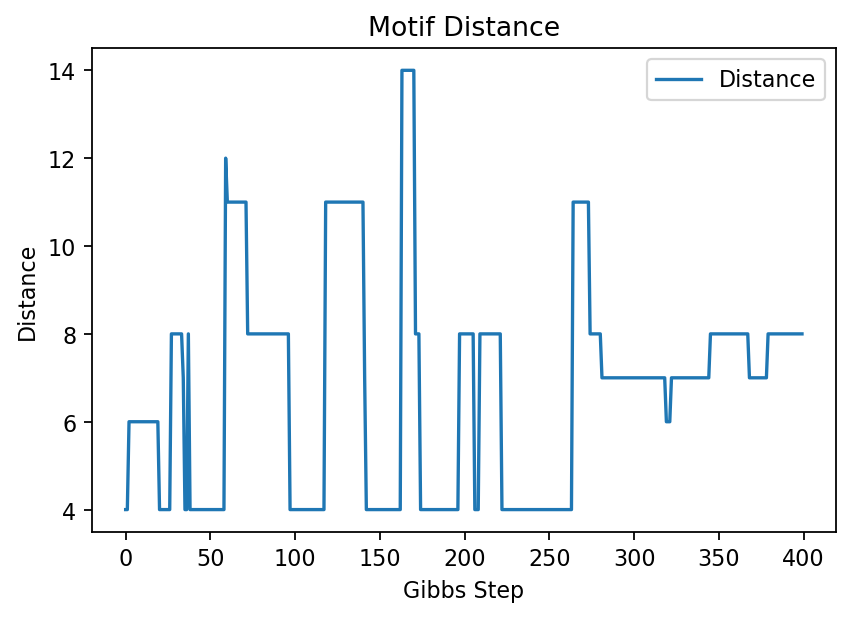

In [422]:
fig = plt.figure(dpi=160)
R = list(map(lambda result: result[0], results))
plt.plot(list(range(400)), R[len(R)-400:], label='Distance')
plt.xlabel('Gibbs Step')
plt.ylabel('Distance')

plt.title('Motif Distance')
plt.legend()

plt.show()

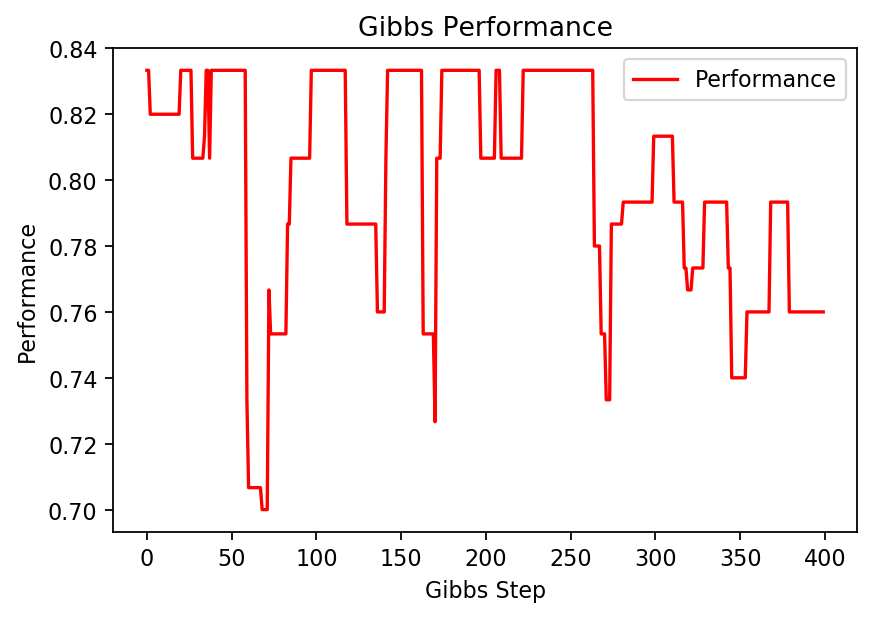

In [421]:
fig = plt.figure(dpi=160)
R = list(map(lambda result: result[1], results))
plt.plot(list(range(400)), R[len(R)-400:], label='Performance', color='red')
plt.xlabel('Gibbs Step')
plt.ylabel('Performance')

plt.title('Gibbs Performance')
plt.legend()

plt.show()

# Results
Found motif of length 15 with maximum of 4 deviations from each lmer: `GTGACACATTATGTC`

I define 2 metrics:
 - ***Motif Distance*** = Maximum distance of the mean motif from all sample motifs
 - ***Gibbs Performance*** = Percentage of mean motif's score where minimum is 33.3333% (mean motif matches exactly one sample motif) and maximum 100% (mean motif matches all sample motifs perfectly). Computation formula: `ScoreFromLecture / (#lmers * MotifLength)` (see [Slide 21](https://dl1.cuni.cz/pluginfile.php/195049/mod_resource/content/18/BioAlg18-6.pdf))

The Motif Distance of found motif is `4`.
The Gibbs Performance of found motif is `83.33%`. That implies that score as we defined it on the lecture is `0.83333333 * 15 * 10 = ~125`.

I tried several parameter settings regarding Gibbs Sampling while most of them did not yield good results. Computation which finally found the desired motif used repeated runs of Gibbs Sampling algorithm with parameters `M=20` and `S=30`, where:
 - `M` stands for the number steps which do not alter the results in a row before a random shift is executed
 - `S` stands for the number shifts that are executed in total
 
I used initial seed `12345` and `beta` for Laplace correction equal to `1 / MotifLength`.

The algorithm with these settings was executed 10 times before it found the motif and took ~364.78s to finish.

Since the computation took that much time, there was too much data to show in a simple graph and so I plot only the performance and maximum distance from mean motif in last 400 steps in plots above.

From the plots we can see that random shifts are necessary part of the algorithm since often the perfomance is not increased in 20 steps in a row even thought it is far from the desired value. We can make the same observation for the Motif Distance plot. That implies that there are many parts of lmers which are very similar a tend to create local optima.

Also from the fact that we had to run the algorithm 10 times before we got the result we can deduce that even the shifts might not be enough to force the algorithm to find the global optima. Therefore, the algorithm's results are very dependent on the initial seed.

Another observation that I made is that the found motif might not (and probably will not) be the best motif hidden in lmers. When I run my test:
```py
# Test
gibbs(['AATATTCG', 'TTTTGTCC', 'GCATTTTT', 'ACTTTTGT'], 4, 1, M=10, S=5, verbose=True)
```
I noticed that the results contain a lot of records with maximum distance `1` that differ in performance score. For example pattern `TTTG` can be found in each lmer with maximum distance `1` but has performance score `0.875`, on the other hand the pattern `TTTT` can be found in each lmer with maximum distance `1` as well but has performance score `0.938`. Therefore, pattern `TTTT` is more likely than `TTTG` but both are acceptable.

There are several ways that could improve the search. We could make it faster by not scoring every step of the search (which I did for monitoring reasons). Another possible improvement might be to choose which lmer to enhance not uniformly but based on more informed statistical distribution (for example based on the distance of current representative motif from the current mean motif). That approach would fasten the convergence but might enlarge the possibility of choosing a local optima. Which could be then addressed by running the algorithm in parallel with several seeds. Each of Gibbs step might run in parallel as well since they are not dependent on each other.

Another possible improvement is to use "relative entropies" rather than frequencies which we talked about on lecture.

Personally, I would try to hasten up the search as much as possible even with the cost of fast convergence and local optima and then try to use Monte Carlo approach and run many computations in parallel with different seeds.

In [423]:
seq2 = loadfasta('MotSamShort.fasta')

In [424]:
seq2.keys()

dict_keys(['Seq0', 'Seq1', 'Seq2', 'Seq3', 'Seq4', 'Seq5', 'Seq6', 'Seq7', 'Seq8', 'Seq9'])

In [427]:
random.seed(12345)

start = time.time()

results = []
iterations = 0
while not any(filter(lambda result: result[0] < 5, results)):
    iterations += 1
    results += gibbs(seq2.values(), length=9, M=20, S=30) # ~25% chance that we will not touch a sequence, we want 30 phase shifts
    print(iterations)

end = time.time()
motif_search_time = end-start

print("Done in {} seconds.".format(motif_search_time))

1
Done in 35.40260148048401 seconds.


In [428]:
candidates = list(filter(lambda result: result[0] < 5, results))
max_score = 0
best = (None,None,None)
for D, S, M in candidates:
    if S > max_score:
        max_score = S
        best = (D, S, M)

print(best)
motif = 'None'
if best[2] != None:
    motif = ''.join([BASES[b] for b in best[2]])

print('Motif: {}'.format(motif))

(4, 0.7777777777777778, [0, 2, 1, 0, 3, 3, 1, 3, 3])
Motif: ACTAGGTGG


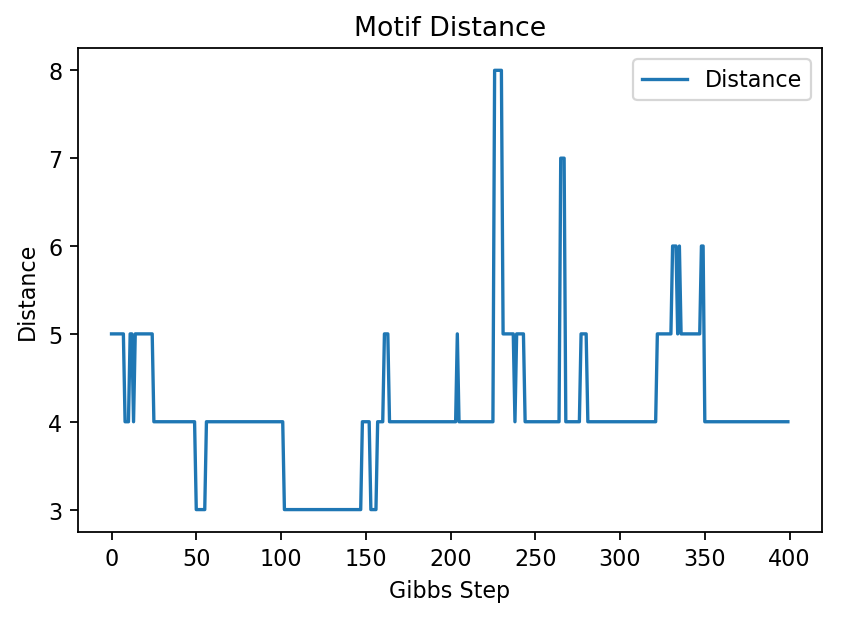

In [437]:
fig = plt.figure(dpi=160)
R = list(map(lambda result: result[0], results))
plt.plot(list(range(400)), R[-400:], label='Distance')
plt.xlabel('Gibbs Step')
plt.ylabel('Distance')

plt.title('Motif Distance')
plt.legend()

plt.show()

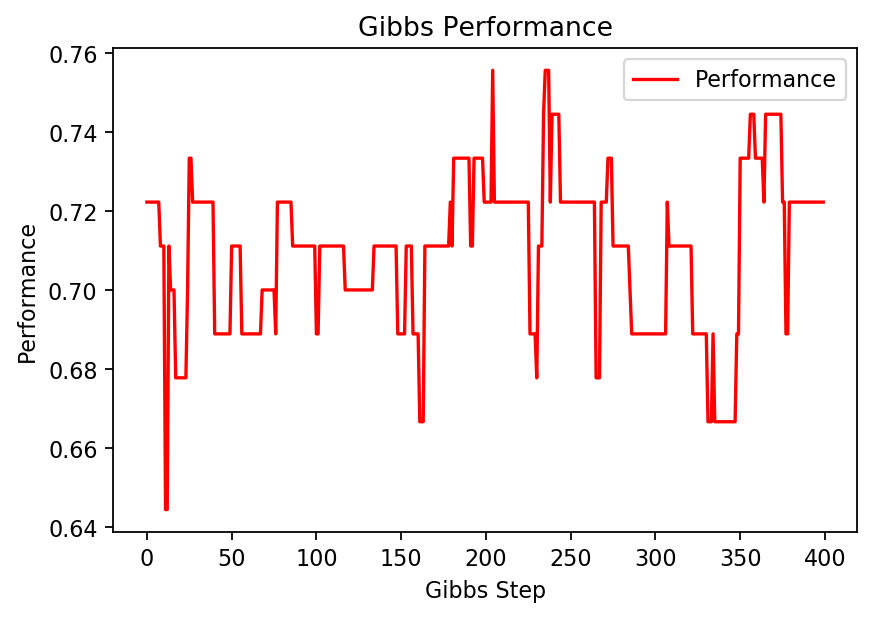

In [436]:
fig = plt.figure(dpi=160)
R = list(map(lambda result: result[1], results))
plt.plot(list(range(400)), R[len(R)-400:], label='Performance', color='red')
plt.xlabel('Gibbs Step')
plt.ylabel('Performance')

plt.title('Gibbs Performance')
plt.legend()

plt.show()

In [440]:
print(results.index(best))
print(len(results))

3008
4785


# MotSamShort Results
Found motif of length 9 with maximum of 4 deviations from each lmer: `ACTAGGTGG`

The Motif Distance of found motif is 4. The Gibbs Performance of found motif is 77.78%. That implies that score as we defined it on the lecture is `0.7777777 * 9 * 10 = ~70`.

I used the same settings as for `MotSam.fasta` and the algorithm needed only 1 run.

The algorithm needed ~35.4s to finish.

From the plots we can see that this time the algorithm tends to change its performance a lot. I assume that this occures because the motif does not converge as much as it did for `MotSam.fasta`. Which is probably caused by the length of the motif. Because the motif has now length just 9 but number of mutations is still 4, the motif does not converge as much as it did for the motif of length 15. That is because there is "too much randomness" in the motif. 

Another aspect that might have introduce more "randomness" into the search is the Laplace correction which is now due to my choice of `beta` very high (beta is equal to `1/9`) and thus skewes the profiles.

Nevertheless, the randomness introduced into the search might have been helpful since the algorithm needed just 1 run to find the solution.